#<b> Computer Vision:Object Detection -CAR

## **Context**

### **Data Description & Overview**

<br> DATA Overview:
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.
<br>Data description:
- This dataset is provided in a zipped format.
- This zip consists of two folders - Car Images and Annotations. Both these folders consist of two more sub-folders.
- Car Images: Have Train Images and Test Images, Annotations: Have Train Annotations and Test Annotations.
- The Train/Test Images subfolder in the Car Images folder consists of  real images of cars as per the make and year of the car.
- The Train/Test Annotations  subfolder in the Annotations folder consists of bounding box region and labels of the images in numberformat eg: 0001
Annotations mentioned like this:
<br>ImageName, Bounding Box Coordinates and Image class in nuber format
<br>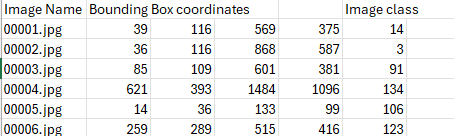

### **Objective**

**Object Detection**, as we have learnt, is in some ways **a combination of classification and regression.** In this case study,  we will apply Convolutional Neural Networks from Deep Learning for Object Detection from scratch and we will  build a model that would help in detecting car model and make and  classify its respective label along with identifying its bounding rectangle. This comprises developing a strong test harness for estimating the model's performance, saving the model and then loading it to make predictions on new data.<br>

### **Mounting the Drive**

The following code gives Google Colab access to Google Drive, so that we can load and utilize our files directly from Google Drive. Please run the following code to mount your Google Drive files:

In [1]:
# Mounting the drive to load the data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Unzipping the Data**

In [5]:
# Unzipping the zip file which contains the data
!unzip -q "/content/drive/MyDrive/AIML/projects/ComputerVison/Capstone/MNIST_Object_Detection.zip"

unzip:  cannot find or open /content/drive/MyDrive/AIML/projects/ComputerVison/Capstone/MNIST_Object_Detection.zip, /content/drive/MyDrive/AIML/projects/ComputerVison/Capstone/MNIST_Object_Detection.zip.zip or /content/drive/MyDrive/AIML/projects/ComputerVison/Capstone/MNIST_Object_Detection.zip.ZIP.


### **Importing the Libraries**

In [2]:
!pip install --upgrade tensorflow==2.17.0
!pip install --upgrade keras
!pip install pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.17.1 which is incompatible.


In [3]:
import os                                 # Importing os module to get the path
from os import listdir                    # Importing listdir module to get the list of directories or files
import numpy as np                        # Imporing numpy for numerical operations
import pandas as pd                       # importing pandas to read csv or txt files
import matplotlib.pyplot as plt           # Importing Matplolib for ploting graphs and visualizing images
import cv2                                # importing opencv to work on images
import seaborn as sns                     # importing seaborn for data visualization
import tensorflow as tf                   # Importing tensorflow for tensor operations or model building
import keras                              # Importing keras for model building
from tensorflow.keras.models import Sequential, Model                 # sequential api for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten           # Importing different layers like dense and flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Activation # importing CNN layers and activations
from tensorflow.keras import backend                                  # Importing backend module to clear backend
from tensorflow.keras.utils import to_categorical                     # Importing to_categorical to perform one-hot encoding
from tensorflow.keras.optimizers import RMSprop,Adam,SGD #Importing optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # regularization method to prevent the overfitting
from tensorflow.keras import losses, optimizers       # importing losses and optimizers from keras
from google.colab.patches import cv2_imshow           # importing cv2_imshow to display images

from sklearn.metrics import mean_absolute_error,mean_squared_error     # importing the error metrics for regression
from sklearn.metrics import accuracy_score, confusion_matrix           # importing the error metrics for classification

# Importing the transfer learning model- VGG16
from tensorflow.keras.applications import VGG16
# importing the ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### **Function to store training data in a list**

In [4]:
from typing import Annotated
## **Function to store training data in a list**

def create_training_data():
  training_data = []                                                            # Creating a list to store the training data
  IMG_SIZE=300                                                                  # initializing image size to 300
  # get the path/directory
  folder_dir = "/content/drive/MyDrive/AIML/projects/Capstone/Car Images/Car Images/Train_Images"                          # path for training images directory
  dirpath = "/content/drive/MyDrive/AIML/projects/Capstone/Annotations/Annotations/Train_Annotations.csv"                             # path for training labels directory

  list_par_dir=[file for file in os.listdir(folder_dir)]                        # separating the image name from extension and storing it in a list like 0.png is stored as 0 and 99.png is stored as 99.
  list_dir={}
  #print(list_par_dir[0])

  for i in list_par_dir:
    foldpath =  str(folder_dir)+"/"+str(i)
    #print(foldpath)

    if os.path.isdir(foldpath):
      for file in list(os.listdir(str(foldpath))):
        if file.endswith(".jpg") and type(file.split(".")[0])== 'int':
          list_dir[int(file.split(".")[0])]= os.path.join(foldpath+"/"+file)
        else:
          list_dir[int(file.split(".")[0].split(" ")[0])]= os.path.join(foldpath+"/"+file)

  dirlist= set(list_dir.keys())
  #print(list_dir.keys())
  dirlist=list(dirlist)
  dirlist.sort()
  df = pd.read_csv(dirpath)
  data = df.set_axis(['ImageName', 'xmin', 'ymin', 'xmax', 'ymax','ImageClass'], axis=1)
  data["ImageKey"]= [ int(x.split(".")[0]) for x in data["ImageName"] ]
  # Sort the DataFrame by the 'Name' column in ascending order
  data.sort_values("ImageKey", axis=0, ascending=True, inplace=True,na_position='last')
  label_dir=df['Image class'].values
  #print(len(list_dir.keys()))
  #print(len(data))
  #print(data.head())
  #print(data[data["ImageKey"]==1]["ImageName"])

  #z=[ z for z in list_dir.keys() if z not in data["ImageKey"]]
  #print(list_dir[8144])
  #print(data["ImageKey"])
  for image in sorted(list_dir.keys()):
    #print(list_dir[image])
    if image in data["ImageKey"].values:
      label= data[data["ImageKey"]==image]["ImageClass"]
      # Storing the four bounding boxes
      xmin=data[data["ImageKey"]==image]['xmin']
      xmax=data[data["ImageKey"]==image]['xmax']
      ymin=data[data["ImageKey"]==image]['ymin']
      ymax=data[data["ImageKey"]==image]['ymax']
      #print(list_dir[images])
      img_array = cv2.imread(list_dir[image])
      # Resizing each image to image_size=300 as we require each image to be of the same size before training the model without missing any image of a different size
      #new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      training_data.append([img_array,label.values[0],(xmin,ymin,xmax,ymax)])

  return training_data


# calling the create_training_data function
training_data=create_training_data()



### **Function to create testing data**

In [5]:
from typing import Annotated
## **Function to store training data in a list**

def create_testing_data():
  testing_data = []                                                            # Creating a list to store the training data
  IMG_SIZE=300                                                                  # initializing image size to 300
  # get the path/directory
  folder_dir = "/content/drive/MyDrive/AIML/projects/Capstone/Car Images/Car Images/Test_Images"                          # path for training images directory
  dirpath = "/content/drive/MyDrive/AIML/projects/Capstone/Annotations/Annotations/Test_Annotation.csv"                             # path for training labels directory
  list_par_dir=[file for file in os.listdir(folder_dir)]                        # separating the image name from extension and storing it in a list like 0.png is stored as 0 and 99.png is stored as 99.
  list_dir={}
  #print(list_par_dir[0])
  for i in list_par_dir:
    foldpath =  str(folder_dir)+"/"+str(i)
    #print(foldpath)
    if os.path.isdir(foldpath):
      for file in list(os.listdir(str(foldpath))):
        if file.endswith(".jpg") and type(file.split(".")[0])== 'int':
          list_dir[int(file.split(".")[0])]= os.path.join(foldpath+"/"+file)
        else:
          list_dir[int(file.split(".")[0].split(" ")[0])]= os.path.join(foldpath+"/"+file)

  dirlist= set(list_dir.keys())
  #print(list_dir.keys())
  dirlist=list(dirlist)
  dirlist.sort()
  df = pd.read_csv(dirpath)
  data = df.set_axis(['ImageName', 'xmin', 'ymin', 'xmax', 'ymax','ImageClass'], axis=1)
  data["ImageKey"]= [ int(x.split(".")[0]) for x in data["ImageName"] ]
  # Sort the DataFrame by the 'Name' column in ascending order
  data.sort_values("ImageKey", axis=0, ascending=True, inplace=True,na_position='last')
  label_dir=df['Image class'].values
  #print(len(list_dir.keys()))
  #print(len(data))
  #print(data.head())
  #print(data[data["ImageKey"]==1]["ImageName"])

  for image in sorted(list_dir.keys()):
    #print(list_dir[image])
    if image in data["ImageKey"].values:
      label= data[data["ImageKey"]==image]["ImageClass"]
      # Storing the four bounding boxes
      xmin=data[data["ImageKey"]==image]['xmin']
      xmax=data[data["ImageKey"]==image]['xmax']
      ymin=data[data["ImageKey"]==image]['ymin']
      ymax=data[data["ImageKey"]==image]['ymax']

      #print(list_dir[images])
      img_array = cv2.imread(list_dir[image])
      #img_array.shape
      # Resizing each image to image_size=300 as we require each image to be of the same size before training the model without missing any image of a different size
      #new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      testing_data.append([img_array,label.values[0],(xmin,ymin,xmax,ymax)])
  return testing_data


# calling the create_training_data function
testing_data=create_testing_data()

In [6]:
training_data[10][0].shape

(424, 640, 3)

### **Splitting the images, labels and bounding boxes**

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []
y_train_boxes=[]
y_test_boxes=[]

for features,labels,boxes in training_data:                                     # Iterating over the training data which is generated from the create_training_data() function
    X_train.append(features)                                                    # Appending images into X_train
    y_train.append(labels)                                                      # Appending labels to y_train
    y_train_boxes.append(boxes)                                                 # Appending bounding boxes to y_train_boxes

for features,labels,boxes in testing_data:                                      # Iterating over the testing data which is generated from the create_testing_data() function
    X_test.append(features)                                                     # Appending images into X_test
    y_test.append(labels)                                                       # Appending labels to y_test
    y_test_boxes.append(boxes)                                                  # Appending bounding boxes to y_test_boxes

In [8]:
#testing_data[0][2]
#print(X_test[0])
#print(y_test_boxes[0])
#print(training_data[10][1])
print(X_train[10].shape)

(424, 640, 3)


Above, we convert the lists to arrays, as mathematical calculations on arrays are computationally faster in comparison to lists. Arrays also take up less space in the memory, and that makes them more suitable for this process, as training requires the data to be loaded into the memory.

In [ ]:
X_train.shape,X_test.shape[1:3]

### **Preprocessing the Data**

In [9]:

def resizeim(bbcoords,imarr,IMG_SIZE):
    wnew,hnew=IMG_SIZE,IMG_SIZE
    calc_factor_w=1
    calc_factor_h=1
    xmin,ymin,xmax,ymax=bbcoords
    w,h=imarr.shape[1],imarr.shape[0]
    #print("..original coords",xmin,ymin,xmax,ymax)
    #print("org image width",w,h)
    if wnew < w:
      calc_factor_w = wnew/w

    if wnew > w:
        calc_factor_w = w/wnew

    if hnew < h:

        calc_factor_h = hnew/h;

    if hnew > h:
        calc_factor_h = h/hnew;
    #print(calc_factor_w,calc_factor_h)
    newX = xmin * calc_factor_w
    newY = ymin * calc_factor_h
    newXMAX = (xmax-xmin) * calc_factor_w+newX
    newYMAX =(ymax-ymin) * calc_factor_h+newY
    #print(newX,newY,newXMAX,newYMAX)
    return (newX,newY,newXMAX,newYMAX)

    #newX+objHeight = (x+objHeight * calc_factor_w) + x
    #newY+objWidth = (y+objHeight * calc_factor_h) + y

#resizeim(51,601,93,393)

In [10]:
# Resizing bounding box relative to image size
y_train_boxes_scaled=[]    # list to stored the scaled bounding boxes
y_test_boxes_scaled=[]     # list to stored the scaled bounding boxes
IMG_SIZE=300

# Resizing the train_boxes
for i in range(len(X_train)):
  value = resizeim(y_train_boxes[i],X_train[i],IMG_SIZE)
  y_train_boxes_scaled.append(value)

#for boxes in y_train_boxes:
  #value = tuple(i/IMG_SIZE for i in boxes)
 # value=resizeim(boxes,,IMG_SIZE)
 # y_train_boxes_scaled.append(value)

# Resizing the test_boxes

for i in range(len(X_test)):
  value = resizeim(y_test_boxes[i],X_test[i],IMG_SIZE)
  y_test_boxes_scaled.append(value)

In [11]:
print(y_train_boxes_scaled[10])
print(y_train_boxes[10])

(10    23.90625
Name: xmin, dtype: float64, 10    65.801887
Name: ymin, dtype: float64, 10    281.71875
dtype: float64, 10    278.066038
dtype: float64)
(10    51
Name: xmin, dtype: int64, 10    93
Name: ymin, dtype: int64, 10    601
Name: xmax, dtype: int64, 10    393
Name: ymax, dtype: int64)


### <b> Visualizing the Images

Text(0.5, 1.0, 'Image corresponds to: 88')

<Figure size 10000x10000 with 0 Axes>

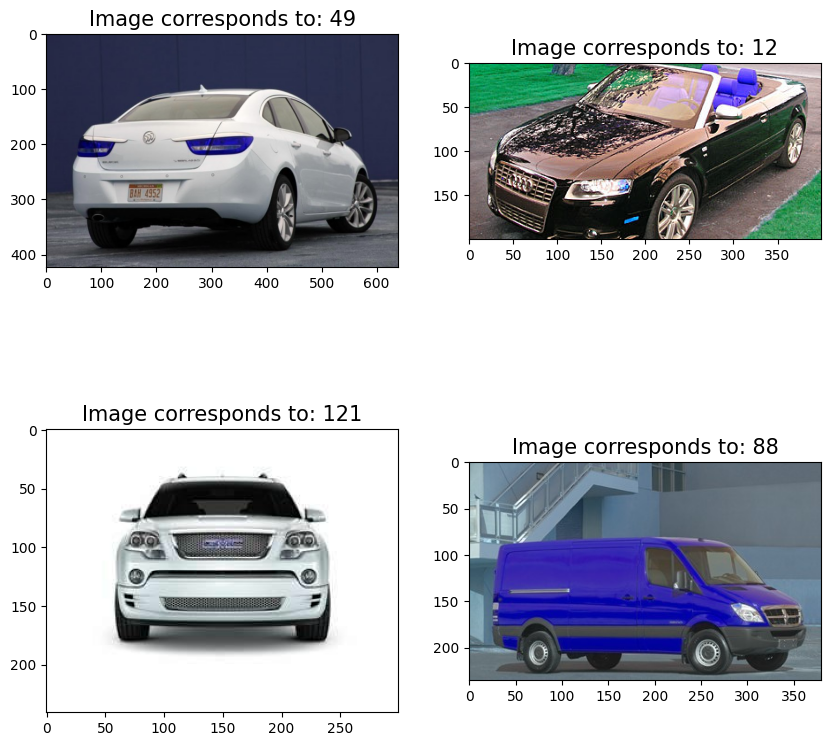

In [12]:
f = plt.figure(figsize=(100,100))
f, axarr = plt.subplots(2,2,figsize=(10,10))
axarr[0,0].imshow(X_train[10])
axarr[0,0].set_title("Image corresponds to: " + str(y_train[10]),{'fontsize':15})
axarr[0,1].imshow(X_train[200])
axarr[0,1].set_title("Image corresponds to: " + str(y_train[200]),{'fontsize':15})
axarr[1,0].imshow(X_train[300])
axarr[1,0].set_title("Image corresponds to: " + str(y_train[300]),{'fontsize':15})
axarr[1,1].imshow(X_train[400])
axarr[1,1].set_title("Image corresponds to: " + str(y_train[400]),{'fontsize':15})


### <b> Visualizing the Bounding Boxes

In [13]:
y_train_boxes[10]
y_train_boxes_scaled[10]

(10    23.90625
 Name: xmin, dtype: float64,
 10    65.801887
 Name: ymin, dtype: float64,
 10    281.71875
 dtype: float64,
 10    278.066038
 dtype: float64)

In [14]:
X_train_resized = [cv2.resize(img, (300, 300)) for img in X_train]
X_test_resized = [cv2.resize(img, (300, 300)) for img in X_test]
# Converting the lists to numpy arrays and reshaping them to (300,300,3)
X_train_resized=np.array(X_train_resized).reshape(np.array(X_train_resized).shape[0],300,300,3)
X_test_resized=np.array(X_test_resized).reshape(np.array(X_test_resized).shape[0],300,300,3)

In [15]:
#function to plot rounding boxes
def plot_boxes(index):
  (startX, startY,endX, endY) = y_train_boxes_scaled[index]                     # Getting the coordinates of the boxes
  image = X_train_resized[index]                                                       # Getting the image
  print(startX, startY,endX, endY)
  label = y_train[index]
  print(label)                                                        # Getting the label
  imgHeight, imgWidth, _ = image.shape
  print(image.shape)                                         # Getting the height and width of the image
  thick = int((300 + imgWidth) // 900)                                    # Giving a random thickness value for the rectangle
  color = (0,255,0)                                                             # Giving a color to the rectangle box

  # plotting the rectangle on the image with title
  cv2.rectangle(image,(int(startX.values[0]), int(startY.values[0])), (int(endX.values[0]), int(endY.values[0])), (0,255,0), thick)            # Plotting the rectangle box on the image
  cv2.putText(image, str(label), (int(startX.values[0]), int(startY.values[0]) - 12), 0, 1* imgHeight, color)
  plt.title("Image corresponds to: " + str(label),{'fontsize':15})
  plt.imshow(image)



10    23.90625
Name: xmin, dtype: float64 10    65.801887
Name: ymin, dtype: float64 10    281.71875
dtype: float64 10    278.066038
dtype: float64
49
(300, 300, 3)


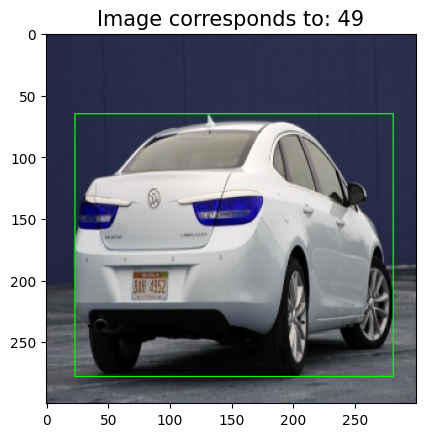

In [16]:
plot_boxes(10)

2    39.84375
Name: xmin, dtype: float64 2    68.125
Name: ymin, dtype: float64 2    281.71875
dtype: float64 2    238.125
dtype: float64
91
(300, 300, 3)


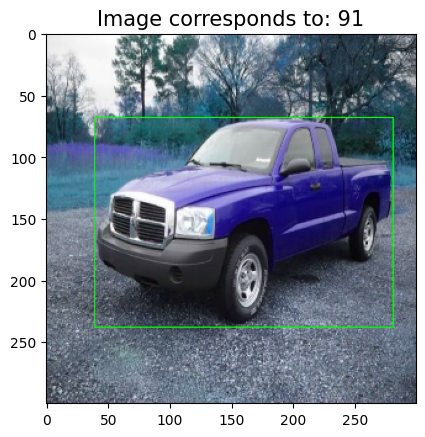

In [17]:
plot_boxes(2)

565    78.0
Name: xmin, dtype: float64 565    84.772727
Name: ymin, dtype: float64 565    237.3
dtype: float64 565    237.045455
dtype: float64
29
(300, 300, 3)


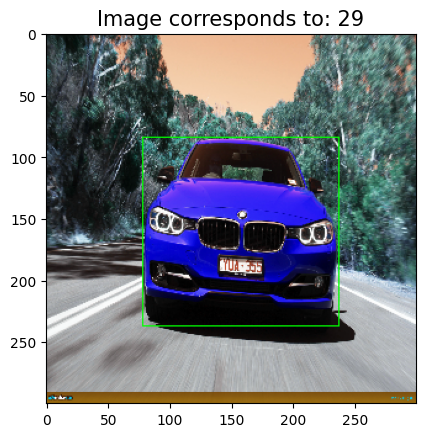

In [18]:
plot_boxes(565)

88    14.355469
Name: xmin, dtype: float64 88    76.171875
Name: ymin, dtype: float64 88    293.847656
dtype: float64 88    241.015625
dtype: float64
20
(300, 300, 3)


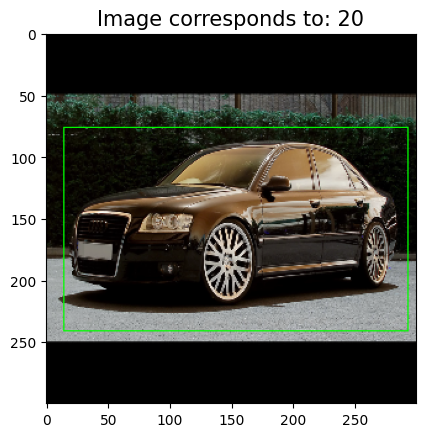

In [19]:
plot_boxes(88)

### <b>Note: Images with Inaccurate Bounding Boxes

### **Converting the list into a DataFrame**

In [20]:
# Converting the list into DataFrame to define the label column so that this can be used along with its axis during predictions and the dataframe operations can be easily implemented
y_train = pd.DataFrame(y_train, columns=["Label"],dtype=object)
y_test = pd.DataFrame(y_test, columns=["Label"],dtype=object)

In [21]:
# Storing the value counts of target variable
count=y_train.Label.value_counts()
print(count)
print('*'*10)
count=y_train.Label.value_counts(normalize=True)
print(count)

Label
119    68
79     49
161    48
167    48
144    47
       ..
175    31
64     30
158    29
99     28
136    24
Name: count, Length: 196, dtype: int64
**********
Label
119    0.008350
79     0.006017
161    0.005894
167    0.005894
144    0.005771
         ...   
175    0.003806
64     0.003684
158    0.003561
99     0.003438
136    0.002947
Name: proportion, Length: 196, dtype: float64


### <b> Converting the target features into arrays

In [22]:
y_train=y_train.astype('float')
y_test=y_test.astype('float')

# Converting the pixel values into Numpy array as arrays are computationally faster as compared to lists
y_train_boxes_scaled= np.array(y_train_boxes_scaled,dtype='float32')
y_test_boxes_scaled= np.array(y_test_boxes_scaled,dtype='float32')


In [ ]:
# Deleting the y_train_boxes and y_test_boxes variables to use the memory/RAM efficiently.
del y_train_boxes
del y_test_boxes

### <b> Initializing Random Seeds

In [23]:
from tensorflow.keras import backend
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

### Sequential Model Building using Transfer Learning: VGG 16 for classification: CARs identification

In [24]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [26]:
vgg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (300,300,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 300, 300, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 300, 300, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 150, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 150, 150, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 75, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 75, 75, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 37, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [29]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [43]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(197, activation='relu'))
new_model.add(Dense(197, activation='relu'))
new_model.add(Dense(197, activation='sigmoid'))

In [44]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 9, 9, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 197)                 │       8,170,181 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 197)                 │          39,006 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 197)                 │          39,006 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,962,881 (87.60 MB)

 Trainable params: 8,248,193 (31.46 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
# Replace None/NaN values in y_test with 0
y_test['Label'] = y_test['Label'].fillna(0)

# Replace None/NaN values in X_train_resized with 0
X_train_resized = np.nan_to_num(X_train_resized, nan=0.0, posinf=0.0, neginf=0.0)

# Replace None/NaN values in X_test_resized with 0
X_test_resized = np.nan_to_num(X_test_resized, nan=0.0, posinf=0.0, neginf=0.0)
# Ensure y_test['Label'] is of the correct data type
y_test['Label'] = y_test['Label'].astype(int) # or 'category' if using categorical cross-entropy

In [50]:

## Fitting the VGG model
new_model_history = new_model.fit(
    X_train_resized,
    to_categorical(y_train['Label'], num_classes=197),  # One-hot encode labels
    epochs=10,batch_size=64,validation_split=0.1
)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2856s 25s/step - accuracy: 0.0348 - loss: 0.0401 - val_accuracy: 0.0270 - val_loss: 0.0345
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2837s 25s/step - accuracy: 0.0937 - loss: 0.0297 - val_accuracy: 0.0331 - val_loss: 0.0337
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2843s 25s/step - accuracy: 0.1893 - loss: 0.0254 - val_accuracy: 0.0466 - val_loss: 0.0362
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2838s 25s/step - accuracy: 0.2124 - loss: 0.0241 - val_accuracy: 0.0540 - val_loss: 0.0356
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2835s 25s/step - accuracy: 0.2373 - loss: 0.0224 - val_accuracy: 0.0405 - val_loss: 0.0386
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2831s 25s/step - accuracy: 0.2622 - loss: 0.0218 - val_accuracy: 0.0380 - val_loss: 0.0435
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2835s 25s/step - accuracy: 0.2799 - loss: 0.0214 - val_accuracy: 0.0344 - val_loss: 0.0416
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2829s 25s/step - accuracy: 0.3071 - loss: 0

In [51]:
# Evaluating on the Test set
new_model.evaluate(X_test_resized, to_categorical(y_test['Label'], num_classes=197), batch_size=64)

126/126 ━━━━━━━━━━━━━━━━━━━━ 2782s 22s/step - accuracy: 0.0545 - loss: 0.0443


[0.04390709102153778, 0.05534137412905693]

In [56]:
# Function to plot loss, val_loss,
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

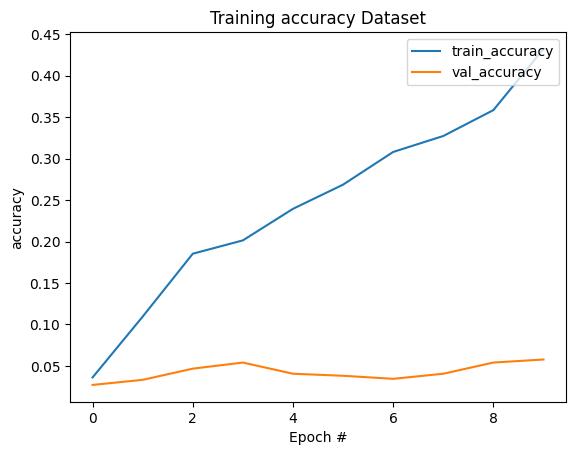

In [53]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history(new_model_history)

In [58]:
# Function to plot loss, val_loss,
def plot_history_fordata(history,type):
    N = len(history.history["accuracy"])
    plt.figure()
    #plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title(type+"accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

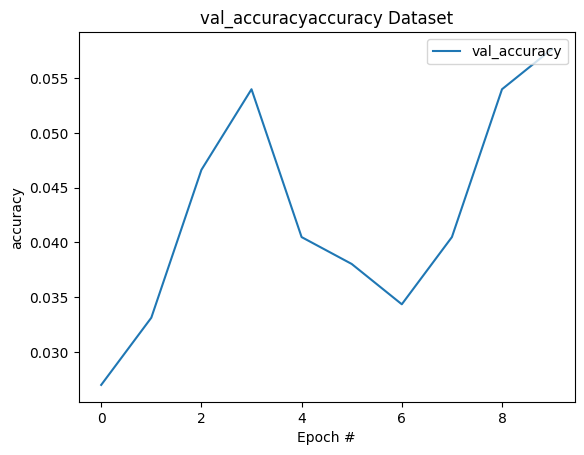

In [62]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history_fordata(new_model_history,"val_accuracy")

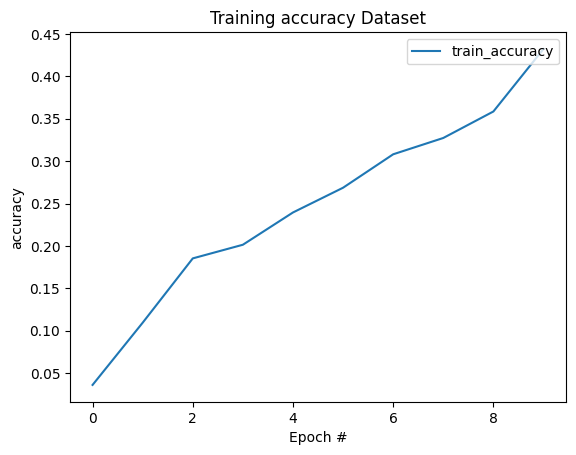

In [64]:
N = len(new_model_history.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), new_model_history.history["accuracy"], label="train_accuracy")
plt.title("Training accuracy Dataset")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend(loc="upper right")


### Sequential Model Building using Transfer Learning: VGG 16 for Regression problem: CAR bounding boxes identification

In [65]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [67]:
vgg_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### <b>Observations